In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


In [3]:
play = pd.read_csv('googleplaystore.csv')
play.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
user = pd.read_csv('googleplaystore_user_reviews.csv')
user.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
play.shape

(10841, 13)

In [6]:
user.shape

(64295, 5)

## Data Exploration

#### Checking null or zero values in data sets:

In [7]:
play.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [8]:
user.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

#### The playstore dataset has 1474 null values (out of 10841) in the 'Rating' column, while 1-10 null values in columns 'Content Rating', 'Current Ver', 'Android Ver' and 'Type'. 

#### The user reviews dataset has 26868 null values (out of 64295) in column 'Translated_Review' and 26863 in 'Sentiment', 'Sentiment_Polarity' and 'Sentiment_Subjectivity'.

In [9]:
play[play==0].count()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

In [10]:
user[user==0].count()

App                          0
Translated_Review            0
Sentiment                    0
Sentiment_Polarity        5163
Sentiment_Subjectivity    4416
dtype: int64

#### There are no zero values in playstore dataset. There are 5163 and 4416 zero values in 'Sentiment_Polarity' and 'Sentiment_Subjectivity' columns of the user reviews dataset.

In [11]:
play.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [12]:
user.describe()

,Sentiment_Polarity,Sentiment_Subjectivity
count,37432.000000,37432.000000
mean,0.182146,0.492704
std,0.351301,0.259949
min,-1.000000,0.000000
25%,0.000000,0.357143
50%,0.150000,0.514286
75%,0.400000,0.650000
max,1.000000,1.000000


#### We have to do imputation for the missing values before we can visualize the relation between variables. We'll use Forward or Back Fill methods since the number of missing values is large.

In [13]:
user['Sentiment_Polarity'].fillna(method='ffill',inplace=True)

In [14]:
user['Sentiment_Subjectivity'].fillna(method='bfill',inplace=True)

In [15]:
user.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity            0
Sentiment_Subjectivity       64
dtype: int64

#### The column 'Sentiment_Subjectivity' still has 64 null values. This means that the rows backward to those of these 64 rows were also null (that's why Back Fill still left them with null values). We'll correct this by using Forward Fill and check null values again.

In [16]:
user['Sentiment_Subjectivity'].fillna(method='ffill',inplace=True)

In [17]:
user.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity            0
Sentiment_Subjectivity        0
dtype: int64

#### Now only the categorical columns have null values.

In [18]:
user['Translated_Review'].fillna(method='ffill',inplace=True)

In [19]:
user['Sentiment'].fillna(method='bfill',inplace=True)

In [20]:
user.isnull().sum()

App                        0
Translated_Review          0
Sentiment                 64
Sentiment_Polarity         0
Sentiment_Subjectivity     0
dtype: int64

In [21]:
user['Sentiment'].fillna(method='ffill',inplace=True)

In [22]:
user.isnull().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

> #### The User Reviews dataset has been fully imputed.

In [23]:
play['Rating']=play['Rating'].fillna(method='ffill')

In [24]:
play.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    1
Genres            0
Last Updated      0
Current Ver       8
Android Ver       3
dtype: int64

#### We'll impute the categorical columns having small no. of null values (between 1 to 10) with the mode of those columns.

In [25]:
play.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [26]:
play['Content Rating']=play['Content Rating'].fillna(play['Content Rating'].mode()[0])

In [27]:
play['Type']=play['Type'].fillna(play['Type'].mode()[0])
play['Current Ver']=play['Current Ver'].fillna(play['Current Ver'].mode()[0])
play['Android Ver']=play['Android Ver'].fillna(play['Android Ver'].mode()[0])

In [28]:
play.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

#### Now all the imputations are done on Playstore and User Reviews datasets. We can start visualization.

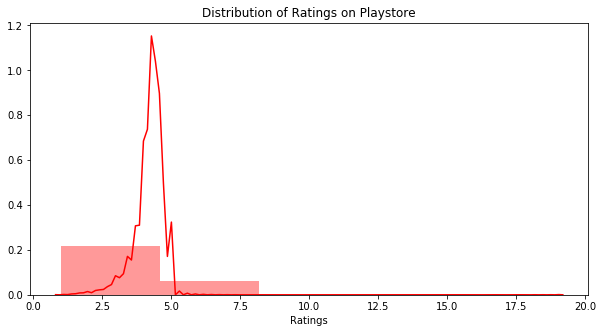

In [29]:
plt.figure(figsize=(10,5))
sns.distplot(play['Rating'],bins=5,color='r')
plt.xlabel('Ratings')
plt.title('Distribution of Ratings on Playstore')
plt.show()

> #### Most of the ratings are distributed between 2.5 and 5.

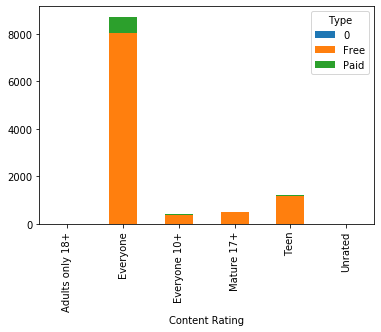

In [30]:
ct = pd.crosstab(play['Content Rating'],play['Type'])
ct.plot.bar(stacked=True)
plt.show()

> #### The stacked bar chart shows that most of the content in all Content Rating categories is free. The maximum paid content is in the "Everyone" category.

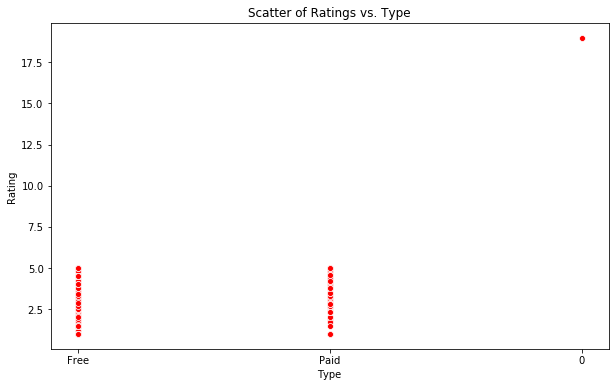

In [43]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=play,x='Type',y='Rating', color='r')
plt.title("Scatter of Ratings vs. Type")
plt.show()

> #### The scatter of ratings between Free type apps and Paid type apps is almost the same.

In [37]:
user.head()
####

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.875000
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


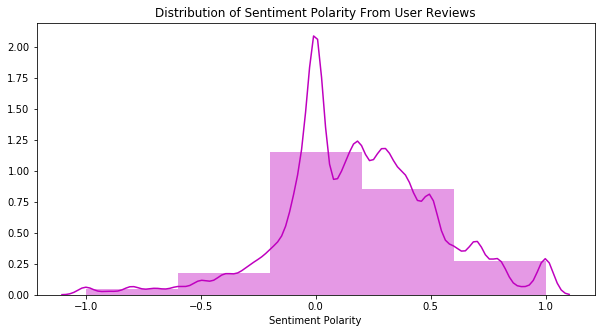

In [38]:
plt.figure(figsize=(10,5))
sns.distplot(user['Sentiment_Polarity'],bins=5,color='m')
plt.xlabel('Sentiment Polarity')
plt.title('Distribution of Sentiment Polarity From User Reviews')
plt.show()

> #### Sentiment Polarity is distributed between -1 and 1 having 0 as the mode.

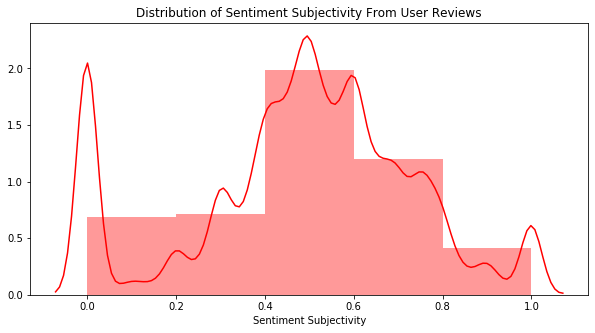

In [74]:
plt.figure(figsize=(10,5))
sns.distplot(user['Sentiment_Subjectivity'],bins=5,color='r')
plt.xlabel('Sentiment Subjectivity')
plt.title('Distribution of Sentiment Subjectivity From User Reviews')
plt.show()

> #### The Sentiment Subjectivity is distributed between 0 to 1.0 with 0.5 being the mode value.

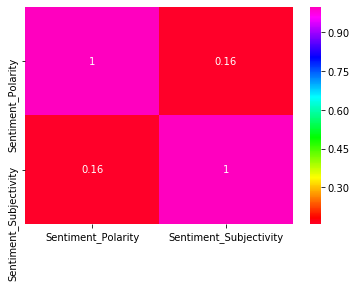

In [35]:
sns.heatmap(user.corr(),cmap='gist_rainbow',annot=True)
plt.show()

> #### There are only two numeric variables in the User Reviews dataset and the correlation between them is 0.16 as showm in the heatmap above.

In [68]:
user['Sentiment'].nunique()

3

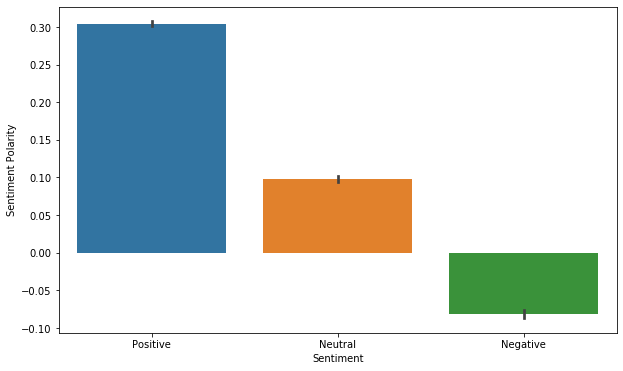

In [69]:
plt.figure(figsize=(10,6))
sns.barplot(data=user,x='Sentiment',y='Sentiment_Polarity')
plt.xlabel("Sentiment")
plt.ylabel("Sentiment Polarity")
plt.show()

> #### A Sentiment is Positive if the value of Sentiment Polarity is between 0 to 0.3. It is Negative if the value is between -0.1 to 0 and neutral if the value is between 0 to 0.1 as shown in the barplot above.

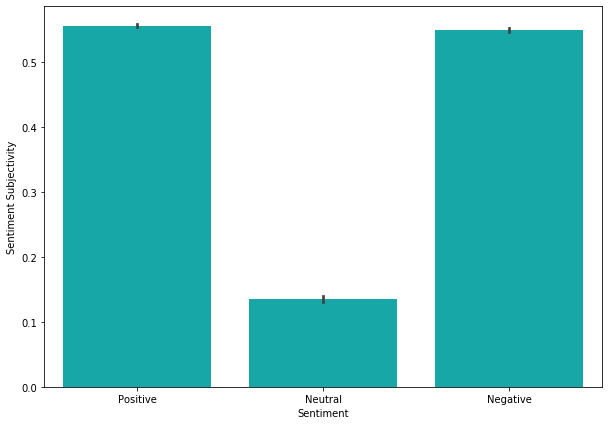

In [73]:
plt.figure(figsize=(10,7))
sns.barplot(data=user,x='Sentiment',y='Sentiment_Subjectivity',color='c')
plt.xlabel("Sentiment")
plt.ylabel("Sentiment Subjectivity")
plt.show()

> #### The Sentiment Subjectivity is between 0 to 0.55 for Positive and Negative Sentiments, while it is between 0 to 0.15 for Neutral Sentiment. This implies that Positive and Negative Sentiments are more subjective as compared to Neutral Sentiment.

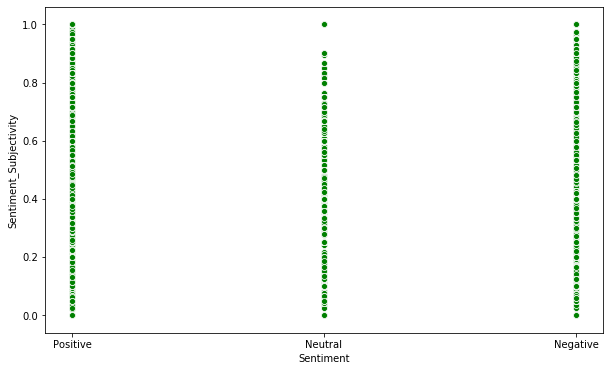

In [76]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=user,x='Sentiment',y='Sentiment_Subjectivity', color='g')
plt.show()

> #### The scatter of Sentiment Subjectivity for Positive, Neutral and Negative Sentiments is very similar.